In [1]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

all_files = os.listdir("txt")
data = pd.DataFrame(columns=['id','content'])

for file in all_files:
    with open("txt/" + file, 'r', encoding='utf-8') as f:
        data.loc[len(data.index)] = [int(file.replace('.txt', '')), f.readlines()]        

In [2]:
import json

file_path = 'type.txt'

with open(file_path, 'r') as file:
    sources = json.load(file)

id_source = pd.DataFrame.from_dict(sources, orient='index').T.melt(var_name='source', value_name='id').dropna(subset=['id'])
data = pd.merge(data, id_source, on='id')
data.head()

id                                            content        source
0    0  [7/1/2021\n, https://www-proquest-com.falcon.l...  Boston Globe
1    1  [7/2/2021\n, https://www-proquest-com.falcon.l...  Boston Globe
2   10  [Find a copy\n, Abstract\n, document 1 of 1\n,...  Boston Globe
3  100  [6/25/2021\n, https://www-proquest-com.falcon....        Others
4  101  [6/25/2021\n, https://www-proquest-com.falcon....        Others

# STEP 1 : Data Cleaning

- get correct paragraph based on 'full text' and 'subject'
- delete URL and Chinese
- tokenizat
- stopwords removal
- pos tag -> lemmatization

In [3]:
empty_list_count = len(data[data['content'].apply(len) == 0])

print("The number of rows with an empty list in 'content':", empty_list_count)
data = data[data['content'].apply(len) > 0]

print("Removed rows with an empty list in 'content'.")

The number of rows with an empty list in 'content': 0
Removed rows with an empty list in 'content'.


In [4]:
import re
        
def get_clean_sentences(row):
    sentences = [sentence[:-1].lower() for sentence in row['content']]
    if "full text" in sentences:
        start_idx = sentences.index("full text")
        sentences = sentences[start_idx+1:]
    if "subject" in sentences:
        end_idx = sentences.index("subject")
        sentences = sentences[:end_idx]
        
    pattern_url = r'^https:\/\/'
    pattern_chinese = re.compile(r'[\u4e00-\u9fff]+') 
    result = [sentence for sentence in sentences if not re.search(pattern_url, sentence) and not re.search(pattern_chinese, sentence)]
    return result

data['clean_sentences'] = data.apply(get_clean_sentences, axis=1)

In [5]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN
    
def lemmatize(tokens):
    # find the pos tagginf for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
    pos_tokens = nltk.pos_tag(tokens)
    
    # lemmatization using pos tag
    lemmatizer = WordNetLemmatizer()
    pos_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos_tokens]
    return pos_tokens

def remove_punctuation_only_strings(strings):
    punctuation_pattern = re.compile(r'^[^\w\s]+$')
    filtered_strings = [s for s in strings if not punctuation_pattern.match(s)]
    return filtered_strings

def tokenize(row):
    sentences = ''.join(row['clean_sentences'])
    words = word_tokenize(sentences)
    
    stops = stopwords.words('english')
    stops.extend(["'s","n't"])  
    words = [word for word in words if not word in stops]
    # words = [word for word in words if not word in set(stopwords.words('english'))]
    
    # words = [word for word in words if not all(char in string.punctuation for char in word)]
    words = remove_punctuation_only_strings(words)
    
    words = [word for word in words if len(word) != 1]
    
    words = lemmatize(words)
    return words


data['words'] = data.apply(tokenize, axis=1)
data.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


id                                            content        source  \
0    0  [7/1/2021\n, https://www-proquest-com.falcon.l...  Boston Globe   
1    1  [7/2/2021\n, https://www-proquest-com.falcon.l...  Boston Globe   
2   10  [Find a copy\n, Abstract\n, document 1 of 1\n,...  Boston Globe   
3  100  [6/25/2021\n, https://www-proquest-com.falcon....        Others   
4  101  [6/25/2021\n, https://www-proquest-com.falcon....        Others   

                                     clean_sentences  \
0  [at china king last month, the phone rarely ra...   
1  [on wednesday morning, a newton south high sch...   
2  [when she first read the headlines from georgi...   
3  [the fbi warned of an increase in hate crimes ...   
4  [discrimination against china and chinese peop...   

                                               words  
0  [china, king, last, month, phone, rarely, rang...  
1  [wednesday, morning, newton, south, high, scho...  
2  [first, read, headline, georgia, danielle, kim...  
3  [fbi, warn, increase, hate, crime, asian, amer...  
4  [discrimination, china, chinese, people, nothi...

# STEP 2 : TF-IDF

## single source test

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

one_source = data.loc[data['source'] == 'Others']
tokenized_list_of_sentences = one_source['words'].tolist()
# tokenized_list_of_sentences = [['this', 'is', 'one', 'basketball'], ['this', 'is', 'a', 'football']]

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
vecs = vectorizer.fit_transform(tokenized_list_of_sentences)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(-0.5, 799.5, 599.5, -0.5)

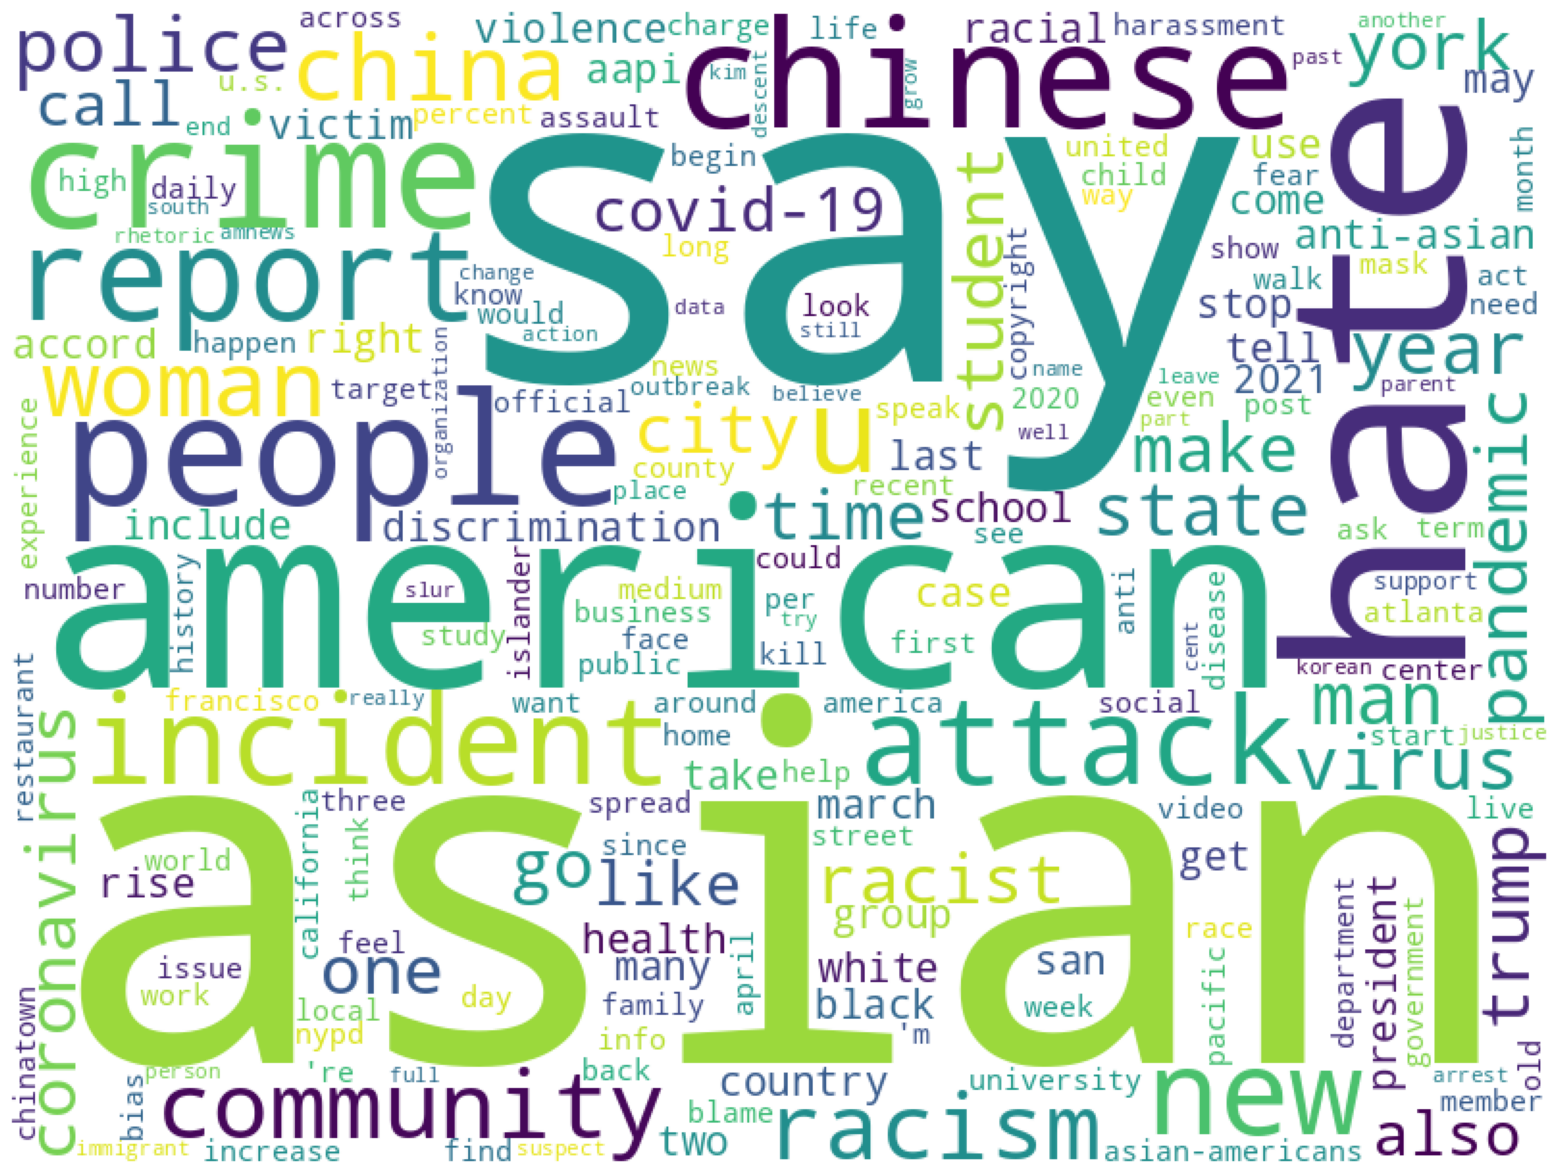

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# cloud = WordCloud(width=1500, height=1200, background_color="white", max_words=200).generate_from_frequencies(df.T.sum(axis=1))

freqs = [(word, vecs.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
cloud = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=200).fit_words(dict(freqs))

plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

## loop

C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== Boston Globe ==============================


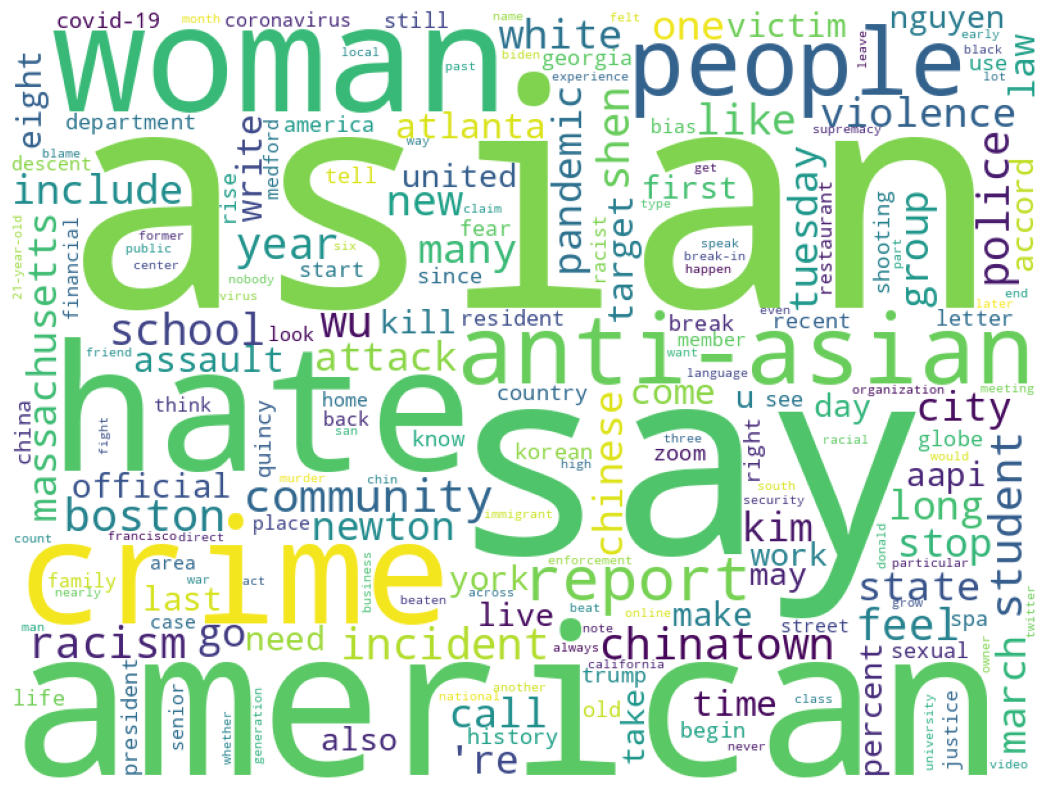

Top 20 words in the word cloud:
['asian', 'say', 'american', 'hate', 'woman', 'crime', 'anti-asian', 'people', 'report', 'community', 'boston', 'student', 'feel', 'shen', 'chinatown', 'school', 'incident', 'year', 'police', 'wu']


C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== Others ==============================


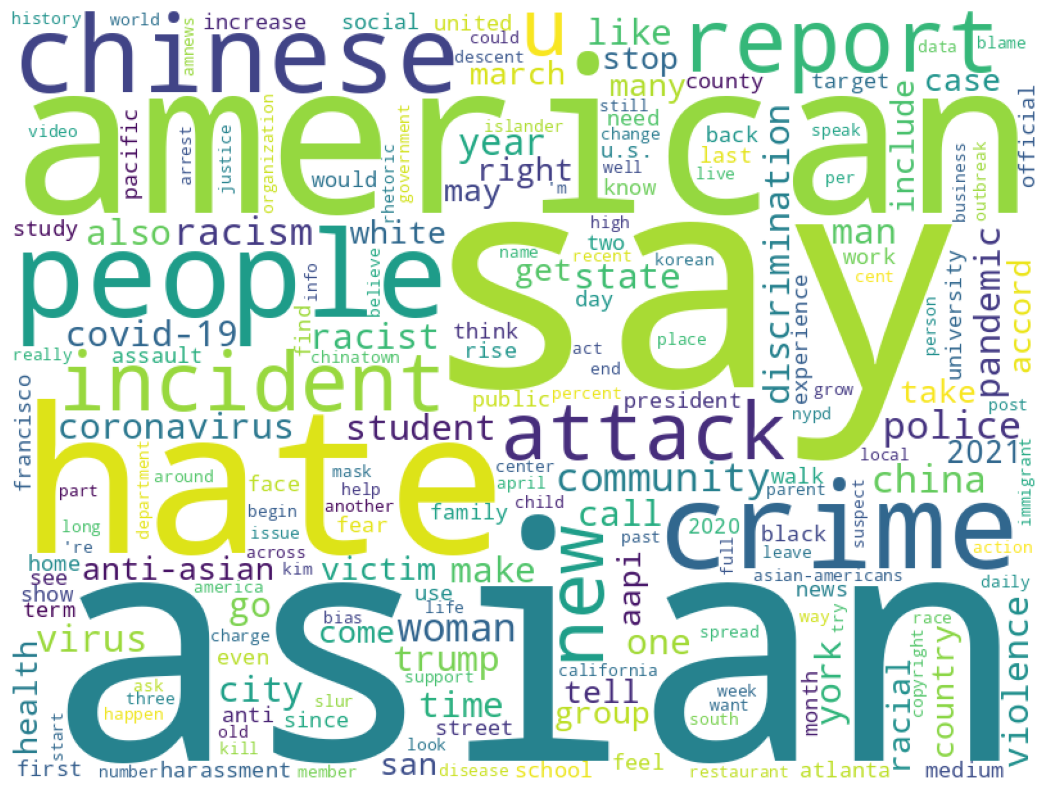

Top 20 words in the word cloud:
['asian', 'say', 'american', 'hate', 'people', 'crime', 'chinese', 'report', 'incident', 'attack', 'u', 'new', 'community', 'woman', 'racism', 'china', 'police', 'virus', 'year', 'man']


C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== Chicago Tribune ==============================


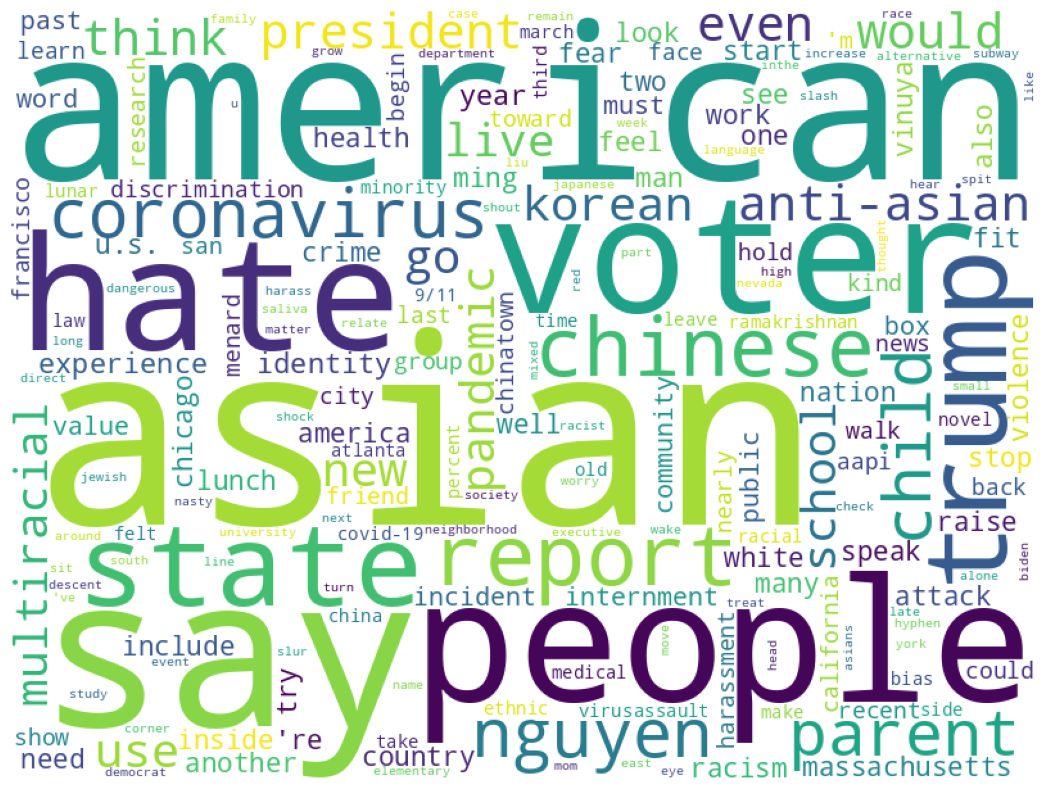

Top 20 words in the word cloud:
['asian', 'american', 'say', 'people', 'voter', 'hate', 'state', 'trump', 'report', 'chinese', 'coronavirus', 'nguyen', 'child', 'parent', 'president', 'think', 'even', 'would', 'anti-asian', 'use']


C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== LA Times ==============================


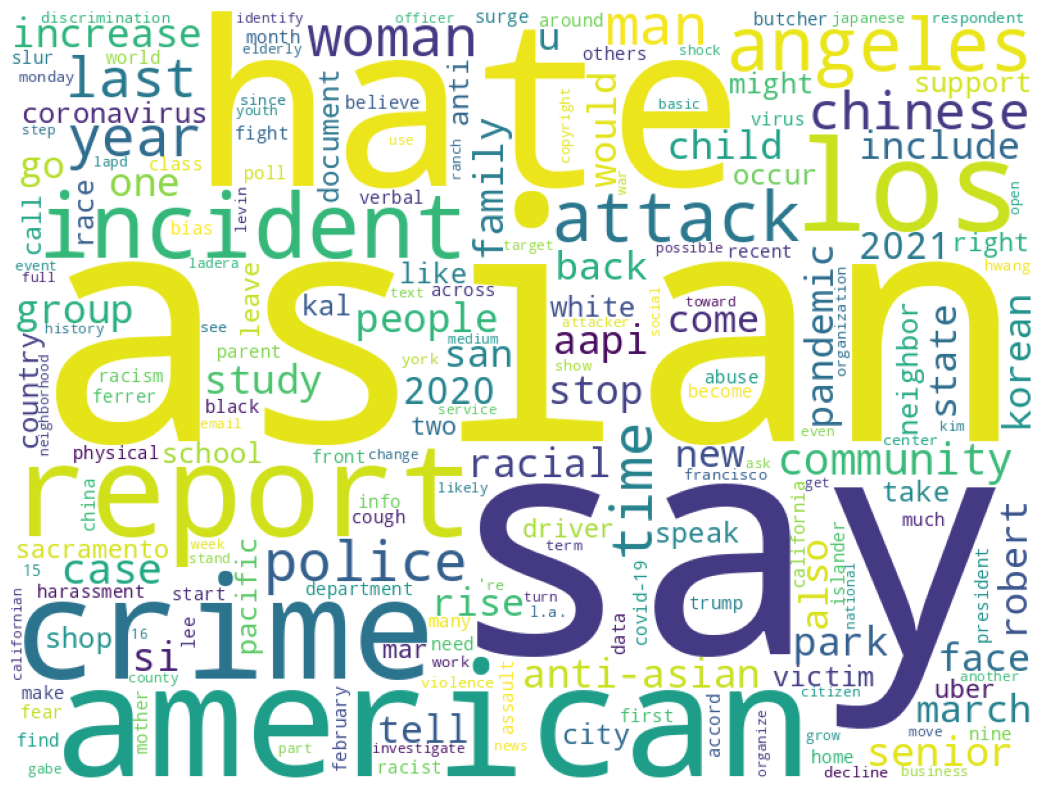

Top 20 words in the word cloud:
['asian', 'say', 'hate', 'american', 'crime', 'report', 'los', 'incident', 'angeles', 'attack', 'time', 'woman', 'police', 'man', 'year', 'last', 'chinese', 'community', 'case', 'senior']


C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== New York Times ==============================


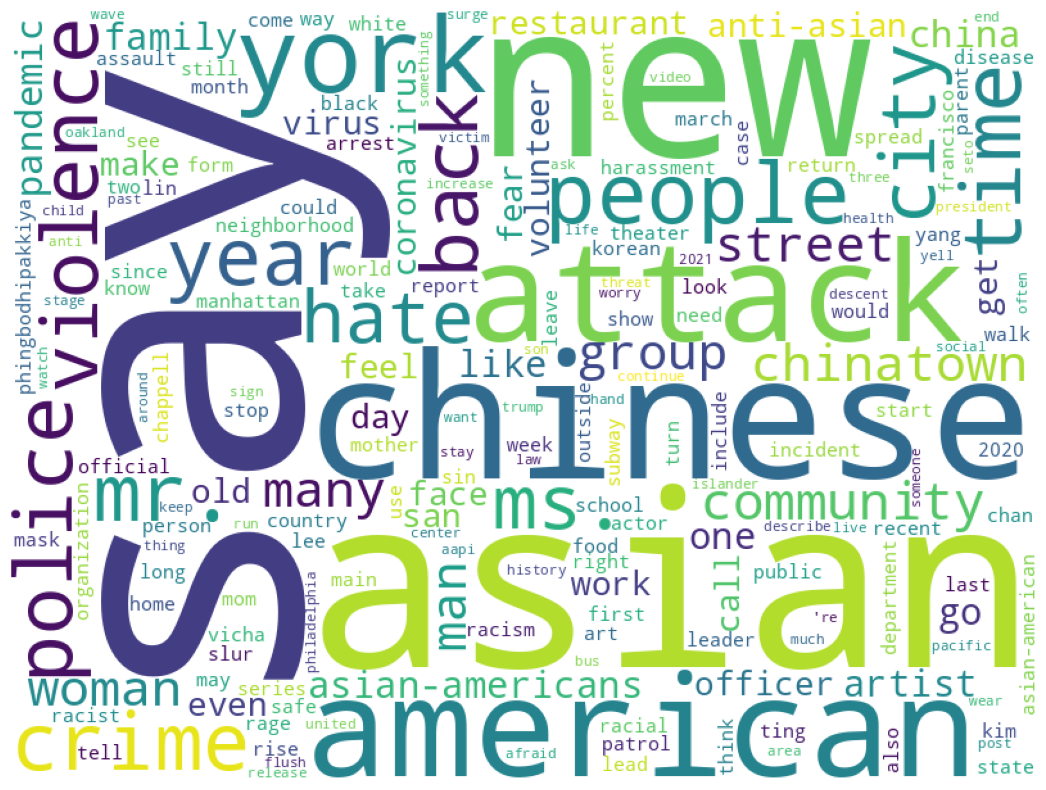

Top 20 words in the word cloud:
['say', 'asian', 'new', 'chinese', 'american', 'attack', 'york', 'people', 'time', 'crime', 'police', 'mr.', 'year', 'violence', 'back', 'city', 'ms.', 'hate', 'community', 'woman']


C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== Star Tribune ==============================


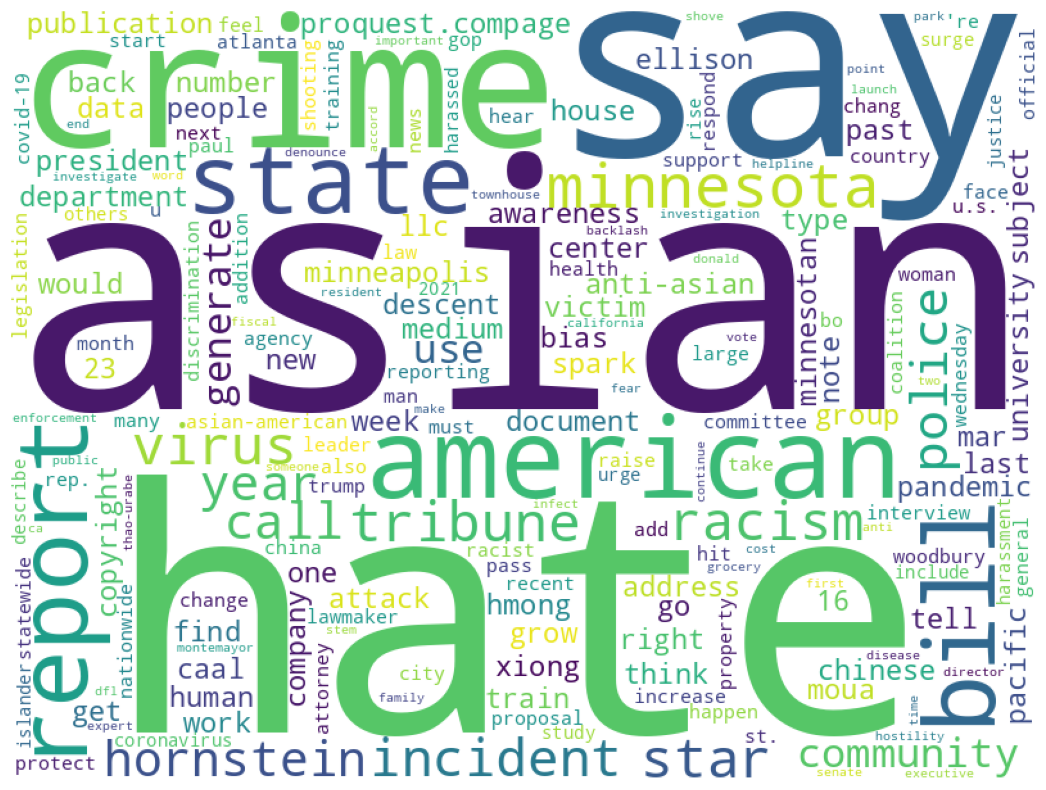

Top 20 words in the word cloud:
['asian', 'hate', 'say', 'crime', 'american', 'report', 'bill', 'state', 'minnesota', 'star', 'tribune', 'virus', 'racism', 'incident', 'police', 'year', 'call', 'hornstein', 'community', 'use']


C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== USA Today ==============================


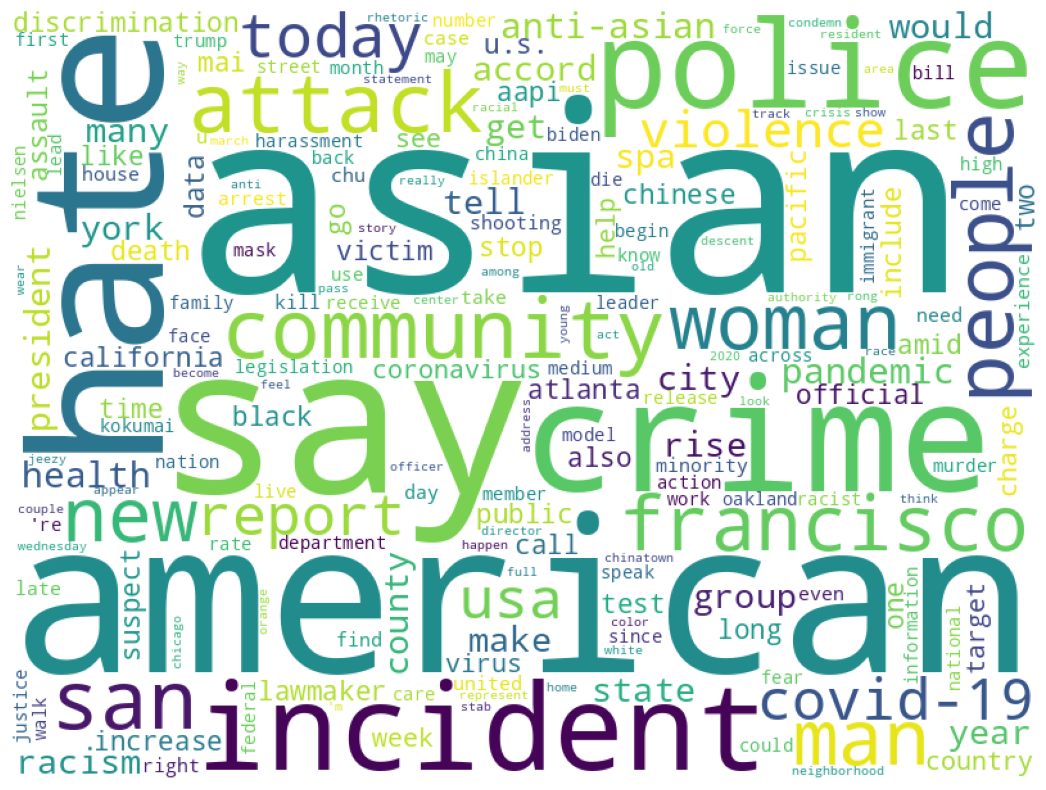

Top 20 words in the word cloud:
['asian', 'american', 'say', 'hate', 'crime', 'police', 'incident', 'community', 'attack', 'people', 'san', 'woman', 'francisco', 'man', 'new', 'today', 'report', 'usa', 'covid-19', 'violence']


C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== Washington Post ==============================


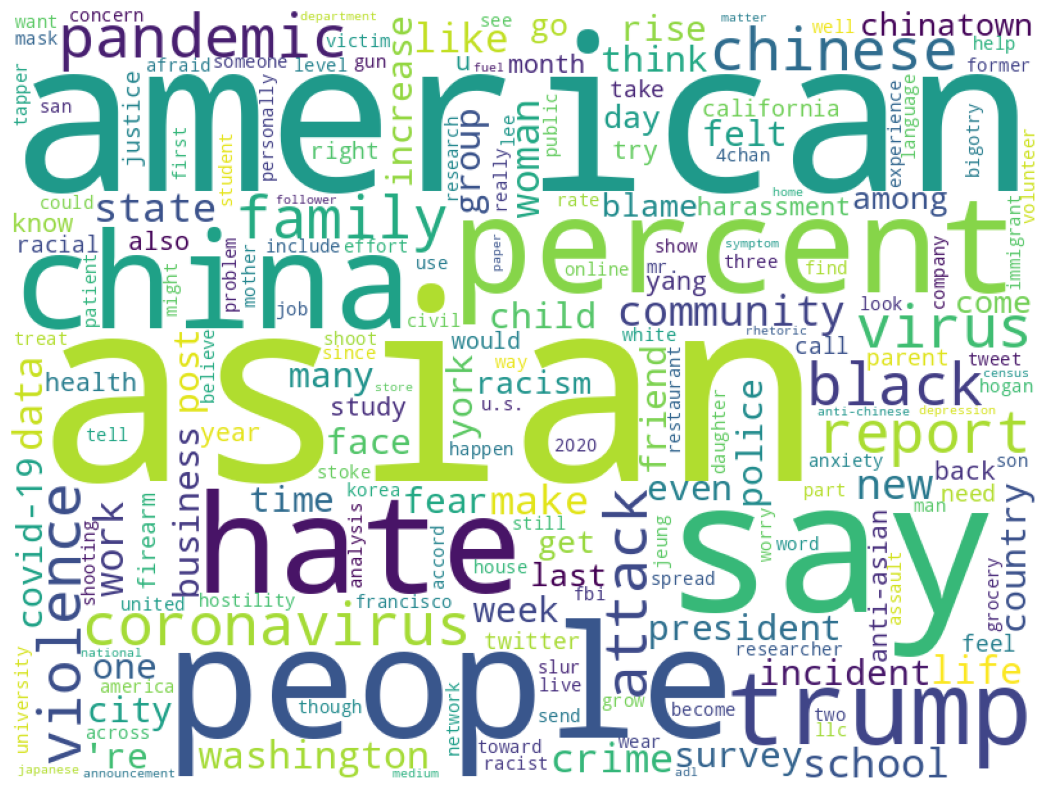

Top 20 words in the word cloud:
['asian', 'american', 'say', 'people', 'hate', 'percent', 'china', 'trump', 'pandemic', 'chinese', 'black', 'coronavirus', 'report', 'virus', 'violence', 'attack', 'family', 'community', 'new', 'make']


C:\Users\henry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


============================== News Magazines ==============================


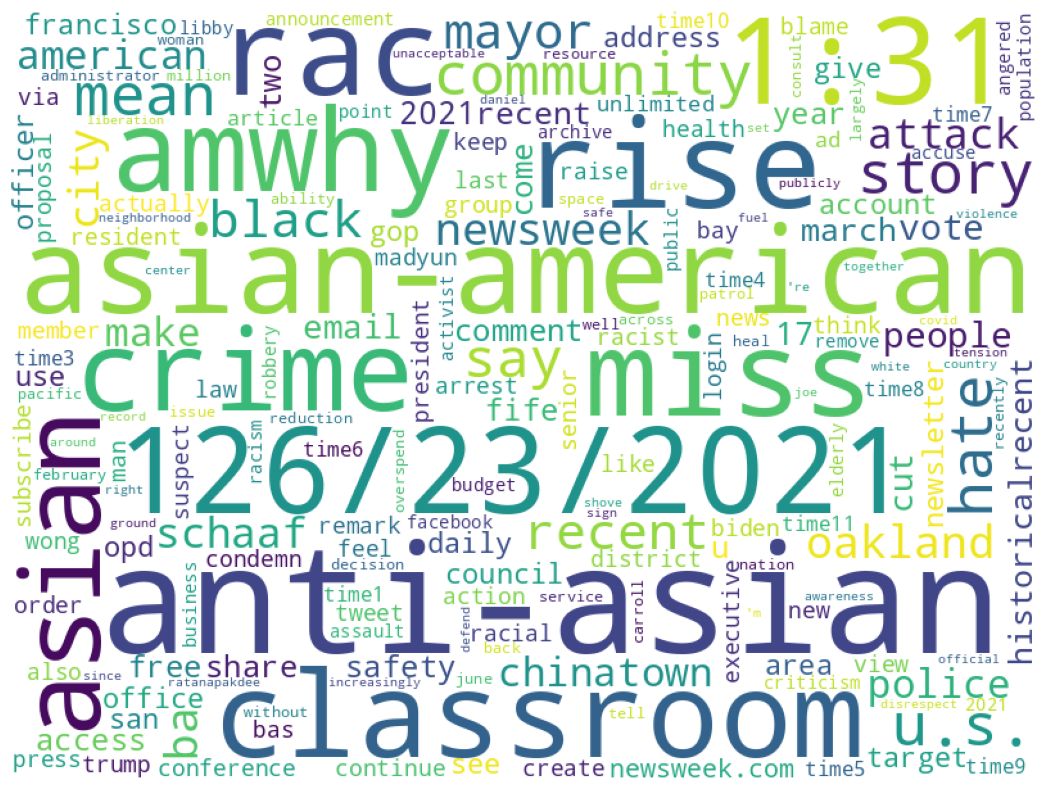

Top 20 words in the word cloud:
['anti-asian', 'rise', 'rac', 'asian-american', 'miss', 'classroom', '126/23/2021', '1:31', 'amwhy', 'crime', 'asian', 'community', 'mean', 'hate', 'u.s.', 'story', 'say', 'recent', 'black', 'mayor']


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def identity_tokenizer(text):
    return text

def TFIDF_and_wordcloud(source):
    one_source = data.loc[data['source'] == source]
    tokenized_list_of_sentences = one_source['words'].tolist()

    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
    vecs = vectorizer.fit_transform(tokenized_list_of_sentences)
    feature_names = vectorizer.get_feature_names_out()
    dense = vecs.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)

    freqs = [(word, vecs.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
    freqs.sort(key=lambda x: x[1], reverse=True)  # Sort frequencies in descending order
    top_20_words = [word for word, _ in freqs[:20]]  # Get top 20 words

    cloud = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=200).fit_words(dict(freqs))

    print("==="*10, source, "==="*10)
    plt.figure(figsize=(15,10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

    print("Top 20 words in the word cloud:")
    print(top_20_words)
    
for source in data['source'].unique():
    TFIDF_and_wordcloud(source)